### Importing required libraries

In [2]:
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

### Utilities

In [2]:
def regression_plot(x,y,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n_subj - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/DF) * (1.0/n_subj + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    
    

### Importing data

In [3]:
# finn's data set 
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 115


In [39]:
# extended data set
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
data2 = sio.loadmat('rfMRI_REST1_HCP_S500.mat')
gF2 = np.ravel(data2['PMAT24_A_CR'])
data_ext = np.concatenate((data['rest_1_mat'],data2['rest_1_mat']),axis=2)
gF = np.concatenate((gF,gF2))
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 435


In [32]:
#data = sio.loadmat('improved_preproc/rfMRI_REST1_HCP_Q2.mat')
data = sio.loadmat('improved_preproc/rfMRI_REST2_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

### gF score distribution 
The gF score is used to divide subjects in 2 or 3 classes.

In [44]:
n_bins = 3
def plot_hist(n_bins):
    plt.hist(gF, bins=n_bins)
    plt.title("gF score distribution")
    plt.xlabel("gF")
    plt.ylabel("Frequency")
    plt.show()
    return n_bins
    
#interact(plot_hist, n_bins=(1,10,1)) 

# needed for stratified k-fold
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])
print(gF)
print(bins)
print(bin_limits)

[17 17  8 16 22 16 17 15 14 24 10 19 12 22 18  8 14 24 20 13 20 20 19 20 19
 10 21 17 19 18 23 20 11 22 22 22 17 15 21 10 21 17  6 18 11 22 22  9 23 17
  5 16  9 20 15 12 21 20 16 16 15  9 22 18 15 17 14 12 18 18 21 22 20 21 18
 20 20 12 23  7 12 11 14  9 21 20  8 20 20 22 23 12 21  9 18 20 16 21 10  8
 19  7 20 21 20 15 10 18 14 20 18 19 19 22 14  7 11 14 15 21 20 20 17 21 10
 21 22 22 22 24 23 23 24 13 18 20 22 19 13 17 22 17 15 13 13 12  8 14 21 11
 18 16 21 16 10 13 21 21 19 14 14 22 11 19 23 18 22 16  9 20  9 13  6 10 13
  8 21 10 21 15 19  8  9 17 18  7 22 18 10 20 21 14 16 17 20 17 13 20 12 20
  9 12 19  9 14 18  8 15 20 22 14 23 23 19 21 11 18 18 19 18 21 20 22 19 23
 19 22 20  8 22 12 22 20  8 21 20 21 22 16 23  6 15 10 23  6 22  7 20 11 21
  6 20 22 12 19 16 21 17 23 16 18 15 23 18 16 21 12 11 17 17 18 12 19 20 17
 21 18 20  9 17 14 21 15 13 14 12 16 21 21  6 14 13 19 21 18 19 17 14  8  7
 18 12 23 14 11 22  9 14 22 14 15 15 14 16 18 22 21 15 14 15 18 21 22 24 17
 10 21 19 10

### Building of input matrix
Starting from the connectivity matrices of each subject a #subjects x #edges matrix is built selecting for each subject the upper triangular matrix of the connectivity matrix (without the diagonal).

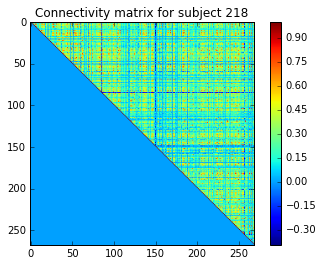

In [41]:
# choose dataset
#conn_mats = data['rest_1_mat']
#conn_mats = data['rest_2_mat']
conn_mats = data_ext
# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj))    
    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]

### Tests
Instead of performing regression in this experiment we try to divide subjects in 2 or 3 classes according to their gF score.
The following tests have been performed:
1. Dimensionality reduction with PCA on training data (to avoid bias) + classification with Random Forest in a LOOCV loop.
2. Two distinct model are built first selecting edges with a significant (positive or negative) correlation with the gF score, than applying PCA and Random Forest classification in a LOOCV loop

When performing PCA, select the number of components such that the amount of variance that needs to be explained is greater than 99.9%.

In [45]:
# Test with all edges (PCA in CV)
loo = cross_validation.LeaveOneOut(n_subj)
errors = np.zeros([n_subj,1])
predictions = np.zeros([n_subj,1])
estimator = RandomForestClassifier(random_state=0, n_estimators=1000, oob_score=True)
pca = PCA(n_components=0.999)

i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    # decomposition
    data_pc = pca.fit_transform(edges[train_index,])
    # regression
    estimator.fit(data_pc,bins[train_index])
    predictions[i] = estimator.predict(pca.transform(edges[test_index,]))

    errors[i] = 1 if predictions[i]==bins[test_index] else 0
    i += 1
    f.value += 1
        
print('Accuracy:',errors.mean())


Accuracy: 0.52183908046


In [37]:
# Test with all edges (no PCA)
loo = cross_validation.LeaveOneOut(n_subj)
errors = np.zeros([n_subj,1])
predictions = np.zeros([n_subj,1])
estimator = RandomForestClassifier(random_state=0, n_estimators=1000, oob_score=True)
pca = PCA(n_components=0.999)

i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    # regression
    estimator.fit(edges[train_index,],bins[train_index])
    predictions[i] = estimator.predict(edges[test_index,])

    errors[i] = 1 if predictions[i]==bins[test_index] else 0
    i += 1
    f.value += 1
        
print('Accuracy:',errors.mean())


Accuracy: 0.719298245614


In [38]:
confusion_matrix(bins, predictions)

array([[ 0, 32],
       [ 0, 82]])

In [16]:
confusion_matrix(bins, predictions)

array([[ 3,  4, 14],
       [ 3,  3, 27],
       [ 2,  4, 55]])

In [9]:
# RF + PCA
print(np.transpose(predictions))
print(bins)

[[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.]]
[2 2 1 2 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 1 2 2 1 2 1 2 2 1 2 2 1 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 2 2
 2 2 2 1 2 1 1 1 1 1 2 2 1 2 2 2 2 1 2 1 2 2 2 2 1 1 2 1 2 2 2 2 1 2 1 2 2
 2 2 2 1]


In [11]:
# RF + PCA (more decision trees)
print(np.transpose(predictions))
print(bins)

[[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.]]
[2 2 1 2 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 1 2 2 1 2 1 2 2 1 2 2 1 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 2 2
 2 2 2 1 2 1 1 1 1 1 2 2 1 2 2 2 2 1 2 1 2 2 2 2 1 1 2 1 2 2 2 2 1 2 1 2 2
 2 2 2 1]


In [17]:
# RF + PCA (more decision trees) - 3 classes
print(np.transpose(predictions))
print(bins)

[[ 3.  3.  3.  3.  3.  3.  3.  3.  1.  3.  1.  3.  3.  1.  3.  3.  3.  3.
   3.  2.  2.  3.  3.  2.  3.  1.  3.  2.  3.  3.  3.  3.  2.  3.  3.  3.
   3.  1.  3.  3.  3.  3.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  1.  3.  3.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  2.  2.  3.  2.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  1.  3.  1.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.]]
[2 2 1 2 3 2 2 2 2 3 1 3 2 3 3 1 2 3 3 2 3 3 3 3 3 1 3 2 3 3 3 3 1 3 3 3 2
 2 3 1 3 2 1 3 1 3 3 1 3 2 1 2 1 3 2 2 3 3 2 2 2 1 3 3 2 2 2 2 3 3 3 3 3 3
 3 3 3 2 3 1 2 1 2 1 3 3 1 3 3 3 3 2 3 1 3 3 2 3 1 1 3 1 3 3 3 2 1 3 2 3 3
 3 3 3 2]


In [7]:
# RF (no PCA)
print(np.transpose(predictions))
print(bins)

[[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.
   2.  1.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  1.  2.  2.  1.  2.  2.  2.  2.  1.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.  1.  2.  2.  2.  2.  2.  2.
   2.  1.  2.  2.  2.  2.  2.  2.  1.  2.  1.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.]]
[2 2 1 2 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 1 2 2 1 2 1 2 2 1 2 2 1 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 2 2
 2 2 2 1 2 1 1 1 1 1 2 2 1 2 2 2 2 1 2 1 2 2 2 2 1 1 2 1 2 2 2 2 1 2 1 2 2
 2 2 2 1]


In [23]:
# RF + PCA on Rest1
print(np.transpose(predictions))
print(bins)

[[ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.]]
[2 2 1 2 3 2 2 2 2 3 1 3 2 3 3 1 2 3 3 2 3 3 3 3 3 1 3 2 3 3 3 3 1 3 3 3 2
 2 3 1 3 2 1 3 1 3 3 1 3 2 1 2 1 2 3 2 2 3 3 2 2 2 1 3 3 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 2 3 1 2 1 2 1 3 3 1 3 3 3 3 2 3 1 3 3 2 3 1 1 3 1 3 3 3 2 1 3 2
 3 3 3 3 3 2]


In [25]:
# RF on Rest1
print(np.transpose(predictions))
print(bins)

[[ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.]]
[2 2 1 2 3 2 2 2 2 3 1 3 2 3 3 1 2 3 3 2 3 3 3 3 3 1 3 2 3 3 3 3 1 3 3 3 2
 2 3 1 3 2 1 3 1 3 3 1 3 2 1 2 1 2 3 2 2 3 3 2 2 2 1 3 3 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 2 3 1 2 1 2 1 3 3 1 3 3 3 3 2 3 1 3 3 2 3 1 1 3 1 3 3 3 2 1 3 2
 3 3 3 3 3 2]


In [43]:
# PCA + RF on extended data
print(np.transpose(predictions))

[[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2. 

In [46]:
# PCA + RF on extended data - 3 classes
print(np.transpose(predictions))

[[ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3. 

In [32]:
# Test with two distinct model for positive and negative edges (PCA on training data)


loo = cross_validation.LeaveOneOut(n_subj)
errors_pos = np.zeros([n_subj,1])
errors_neg = np.zeros([n_subj,1])
predictions_pos = np.zeros([n_subj,1])
predictions_neg = np.zeros([n_subj,1])
estimator = RandomForestClassifier(random_state=0, n_estimators=100, oob_score=True)
pca = PCA(n_components=0.999)



def regress(p,score,edges):
    i=0
    f = FloatProgress(min=0, max=n_subj)
    display(f)
    for train_index, test_index in loo:
        pears = [stats.pearsonr(edges[train_index,i],gF[train_index]) for i in range(0,n_edges)]
        # select edges (positively and negatively) correlated with gF with threshold p
        idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]>0])
        idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]<0])
        filtered_pos = edges[np.ix_(train_index,idx_filtered_pos)]
        filtered_neg = edges[np.ix_(train_index,idx_filtered_neg)]
        # decomposition & regression 
        pc_pos = pca.fit_transform(filtered_pos)
        estimator.fit(pc_pos,bins[train_index])
        predictions_pos[i] = estimator.predict(pca.transform(edges[np.ix_(test_index,idx_filtered_pos)]))
        pc_neg = pca.fit_transform(filtered_neg)
        estimator.fit(pc_neg,bins[train_index])
        predictions_neg[i] = estimator.predict(pca.transform(edges[np.ix_(test_index,idx_filtered_neg)]))
        errors_pos[i] =  1 if predictions_pos[i]==bins[test_index] else 0
        errors_neg[i] =  1 if predictions_neg[i]==bins[test_index] else 0
        i=i+1
        f.value += 1
        
#interact(regress, p=(0.01,0.1,0.01),score=fixed(gF), edges=fixed(edges))
p = 0.01
regress(p,gF,edges)
preds_3 = predictions_pos
preds_4 = predictions_neg

print(np.mean(errors_pos))
print(np.mean(errors_neg))


0.719298245614
0.710526315789


In [34]:
print(np.transpose(preds_3))
print(np.transpose(preds_4))

[[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.]]
[[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.]]


In [9]:
# Test with all edges (PCA in 5-fold CV)
k = 5
cv = cross_validation.StratifiedKFold(bins,k)
errors = np.zeros([n_subj])
predictions = np.zeros([n_subj])
estimator = RandomForestClassifier(random_state=0, n_estimators=100, oob_score=True)
pca = PCA(n_components=0.999)

i=0
f = FloatProgress(min=0, max=k)
display(f)
for train_index, test_index in cv:
    # decomposition
    data_pc = pca.fit_transform(edges[train_index,])
    # regression
    estimator.fit(data_pc,bins[train_index])
    predictions[test_index] = np.ravel(estimator.predict(pca.transform(edges[test_index,])))

    errors[test_index] = predictions[i]==bins[test_index]
    i += 1
    f.value += 1
        
print('Mean error:',errors.mean())
preds_5 = predictions
print(preds_5)

Mean error: 0.719298245614
[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]


In [11]:
# Test with all edges (PCA in 10-fold CV)
k = 10
cv = cross_validation.StratifiedKFold(bins,k)
errors = np.zeros([n_subj])
predictions = np.zeros([n_subj])
estimator = RandomForestClassifier(random_state=0, n_estimators=100, oob_score=True)
pca = PCA(n_components=0.999)

i=0
f = FloatProgress(min=0, max=k)
display(f)
for train_index, test_index in cv:
    # decomposition
    data_pc = pca.fit_transform(edges[train_index,])
    # regression
    estimator.fit(data_pc,bins[train_index])
    predictions[test_index] = np.ravel(estimator.predict(pca.transform(edges[test_index,])))

    errors[test_index] = predictions[i]==bins[test_index]
    i += 1
    f.value += 1
        
print('Mean error:',errors.mean())
preds_6 = predictions
print(preds_6)

Mean error: 0.719298245614
[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]


In [10]:
results = {'rf_improved_1_class_pca_all':preds_1,'rf_improved_1_class_pca_train':preds_2,
           'rf_improved_1_class_pca_pos':preds_3,'rf_improved_1_class_pca_neg':preds_4,
          'rf_improved_1_class_pca_train_5FCV':preds_5,'rf_improved_1_class_pca_train_10FCV':preds_6}
sio.savemat('res_class_randomforest_improved_1.mat',results,appendmat=True)

In [19]:
results = {'rf_improved_2_class_pca_all':preds_1,'rf_improved_2_class_pca_train':preds_2,
           'rf_improved_2_class_pca_pos':preds_3,'rf_improved_2_class_pca_neg':preds_4,
          'rf_improved_2_class_pca_train_5FCV':preds_5,'rf_improved_2_class_pca_train_10FCV':preds_6}
sio.savemat('res_class_randomforest_improved_2.mat',results,appendmat=True)